#Importing Libraries

In [3]:
import numpy as np
from numpy import array
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import plot_model


from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from nltk.translate.bleu_score import corpus_bleu

from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from models import NIC,mergeModel

#Helper functions for preprocessing the data

In [4]:
def loadFile(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    data = file.read()
    file.close()
    return data
def loadImgs(filename):
  text = loadFile(filename)
  imgs = list()

  for sentence in text.split("\n"):
    words = sentence.split(".")
    if len(sentence)<1:
      continue
    img_id = words[0]
    imgs.append(img_id)
  return imgs

def loadDict(imgs,fn):
  mappings = dict()
  text = loadFile(fn)
  sentences = text.split("\n")
  for img in imgs:
    mappings[img] = list()
  for sentence in sentences:
    words = sentence.split()
    if(len(sentence))<1:
      continue
    img_id , caption = words[0],words[1:]
    caption = "<startseq> " + " ".join(caption)+" <endseq>"
    if img_id in imgs:
      mappings[img_id].append(caption)
  return mappings

def getVocabulary(mapped_captions):
    vocab = list()
    for key in mapped_captions.keys():
        for sentence in mapped_captions[key]:
          words = sentence.split()
          for word in words:
              if word not in vocab:
                  vocab.append(word)

    return vocab


def cleaningData(desc):
    table = str.maketrans('','',string.punctuation)
    
    for img_id,caption in desc.items():

        for num,img_caption in enumerate(caption):
            
            img_caption.replace("-"," ")

            cap_l = img_caption.split()
            #converts to lowercase
            cap_l = [each.lower() for each in cap_l]
            #remove punctuation from each token
            cap_l = [each.translate(table) for each in cap_l]
            #remove hanging 's and a 
            cap_l = [each for each in cap_l if(len(each)>1)]
            #remove tokens with numbers in them
            cap_l = [each for each in cap_l if(each.isalpha())]

            #convert back to string
            img_caption = ' '.join(cap_l)
            desc[img_id][num]= img_caption
    return desc

def generateDescriptions(data): 
    mapped_captions = dict()
    text = data
    lines = text.split('\n')

    for line in lines:
        words = line.split()
        if len(line)<2:
            continue 
       
        image, caption = words[0], words[1:]
        caption = ' '.join(caption)
        image = image.split('.')
        image = image[0]
      
        if image not in mapped_captions:
            mapped_captions[image] = []

        mapped_captions[image].append(caption)
    return mapped_captions
def saveText(mappings, filename):
    sentences = []

    for img_name, captions in mappings.items():

        for each in captions:
            sentences.append(img_name + '\t' + each)

    text = "\n".join(sentences)
    final_file = open(filename,"w")
    final_file.write(text)
    final_file.close()

In [5]:

file = "Flickr8k_text/Flickr8k.token.txt"
text = loadFile(file)
print(text[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
captions = generateDescriptions(text)
captions = cleaningData(captions)
print("Total Captions: "+str(len(captions)))

Total Captions: 8092


In [7]:
vocab = getVocabulary(captions)
print(len(vocab))

8763


In [8]:
saveText(captions, "data/clean.txt")

#Loading the data

In [9]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
x_train = loadImgs(filename)
print("Train data: "+str(len(x_train)))

Train data: 6000


In [10]:
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
x_val = loadImgs(filename)
print("Validation data: "+str(len(x_val)))

Validation data: 1000


In [11]:
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
x_test = loadImgs(filename)
print("Test data: "+str(len(x_test)))

Test data: 1000


In [12]:
train=[]
val = []
test = []

for each in x_train:
  each = each+'.jpg'
  train.append(each)

for each in x_val:
  each = each+'.jpg'
  val.append(each)

for each in x_test:
  each = each+'.jpg'
  test.append(each)

In [13]:
print(val[0])

2090545563_a4e66ec76b.jpg


#Extracting photo features

In [14]:
def extractFeatures(images):

  model = InceptionV3(weights='imagenet')  
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  photo_features = dict()
  
  for image in images:
            imagepath = "Flicker8k_Dataset/"+image
            photo = load_img(imagepath, target_size=(299, 299))
            img = img_to_array(photo)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            feature = model.predict(img, verbose=0)
            feature = np.reshape(feature, feature.shape[1])
            photo_features[image] = feature
        
  return photo_features

In [ ]:
encoding_train = {}
encoding_train = extractFeatures(train)
with open("data/encoded_train_imagesh.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [ ]:
encoding_val = {}
encoding_val = extractFeatures(val)
with open("data/encoded_val_imagesh.pkl", "wb") as encoded_pickle:
    dump(encoding_val, encoded_pickle)

In [ ]:
encoding_test = {}
encoding_test = extractFeatures(test)
with open("data/encoded_test_imagesh.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

#Loading photo features

In [15]:
train_features = load(open("data/encoded_train_imagesh.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [16]:
val_features = load(open("data/encoded_val_imagesh.pkl", "rb"))
print('Photos: val=%d' % len(val_features))
print(val_features["1579798212_d30844b4c5.jpg"].shape)

Photos: val=1000
(2048,)


In [17]:
test_features = load(open("data/encoded_test_imagesh.pkl", "rb"))
print('Photos: test=%d' % len(test_features))
print(test_features['241347760_d44c8d3a01.jpg'].shape)

Photos: test=1000
(2048,)


In [18]:
train_data = loadDict(x_train,'data/clean.txt')
val_data = loadDict(x_val,'data/clean.txt')

In [19]:
train_caption = []
for key, captions in train_data.items():
    for caption in captions:
        train_caption.append(caption)
print(len(train_caption))

30000


In [20]:
print(train_caption[:5])

['<startseq> black dog is running after white dog in the snow <endseq>', '<startseq> black dog chasing brown dog through snow <endseq>', '<startseq> two dogs chase each other across the snowy ground <endseq>', '<startseq> two dogs play together in the snow <endseq>', '<startseq> two dogs running through low lying body of water <endseq>']


#Decreasing the vocab size

In [21]:
threshold = 5
word_counts = {}
for sent in train_caption:
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocabulary = [word for word in word_counts if word_counts[word] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocabulary)))
vocab_len = len(vocabulary)+1

preprocessed words 7578 -> 2530


In [22]:
idx2word = dict()
word2idx = dict()

idx = 1
for word in vocabulary:
    word2idx[word] = idx
    idx2word[idx] = word
    idx += 1

In [23]:
print(idx2word[25])


low


In [24]:

print(word2idx['low'])

25


In [25]:
def getMax(mappings):
    mappings_l = list()
    for key in mappings.keys():
      [mappings_l.append(each) for each in mappings[key]]
    max = len(mappings_l[0].split())
    for caption in mappings_l:
      if(len(caption.split())>max):
        max = len(caption.split())
    return max
max_len = getMax(train_data)
print('Maximum caption length: %d' % max_len)

Maximum caption length: 34


#Using data generator due to the limitations of the RAM

In [26]:
def data_generator(mappings, features, word2idx, max_length, batch_size,mode='merge'):
    X1, X2, y = list(), list(), list()
    count=0
    # loop for ever over images
    while True:
        for img, capts in mappings.items():
            count+=1
            # retrieve the photo feature
            feature = features[img+'.jpg']
            random.shuffle(capts)
            for caption in capts:
                # encode the sequence
                seq = [word2idx[word] for word in caption.split(' ') if word in word2idx]
                # split one sequence into multiple X, y pairs
                for n in range(1, len(seq)):
                    # split into input and output pair
                    partial,cap = seq[:n], seq[n]
                    # pad input sequence
                    #print(partial)
                    if mode=='nic':
                      partial = pad_sequences([partial], maxlen=max_length,padding='post')[0]
                    # encode output sequence
                    else:
                      partial = pad_sequences([partial], maxlen=max_length)[0]
                    cap = to_categorical([cap], num_classes=vocab_len)[0]
                    # store
                    X1.append(feature)
                    X2.append(partial)
                    y.append(cap)
            # yield the batch data
            if count==batch_size:
                if mode=='nic':
                    yield [array(X1), array(X2),np.zeros([array(X2).shape[0],312]),np.zeros([array(X2).shape[0],312])], array(y)
                else:
                    yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                count=0

#Defining the model

In [27]:
model1 = NIC(256,vocab_len,max_len)
model2 = mergeModel(300,vocab_len,max_len)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 256)            0         
Total params: 532,736
Trainable params: 528,640
Non-trainable params: 4,096
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 256)           647936    
________________________

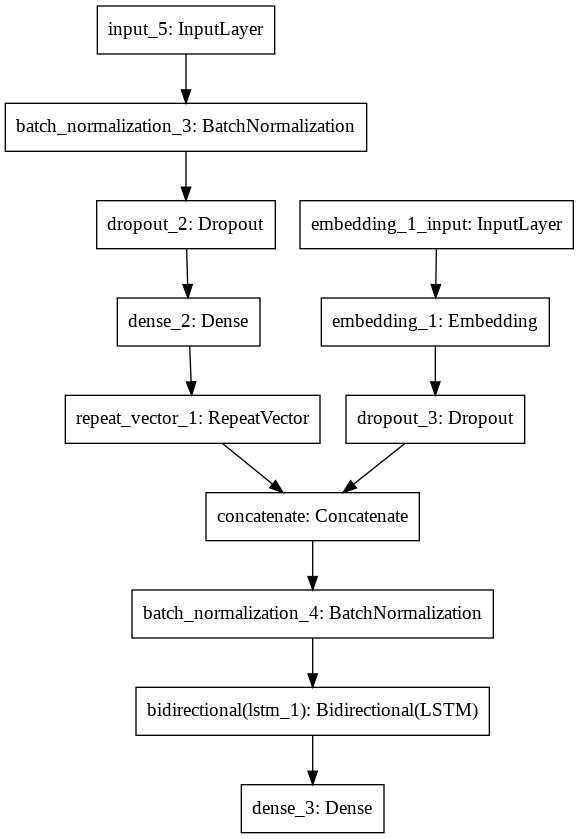

In [28]:
plot_model(model1,"images/NIC.png")
plot_model(model2,"images/merge.png")

#Training the model

In [29]:
epochs = 10
batch_len = 15
val_batch = 3
steps = len(train_data)//batch_len
val_steps = len(val_data)//val_batch

for i in range(epochs):
    
    generator = data_generator(train_data, train_features, word2idx, max_len,batch_len )
    val_gen = data_generator(val_data, val_features, word2idx, max_len,val_batch )

    model2.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)


400/400 [==============================] - 167s 418ms/step - loss: 2.6260 - accuracy: 0.3886 - val_loss: 3.2121 - val_accuracy: 0.3389


In [32]:
model2.optimizer.lr = 0.0001
for i in range(3):
    
    generator = data_generator(train_data, train_features, word2idx, max_len,batch_len )
    val_gen = data_generator(val_data, val_features, word2idx, max_len,val_batch )

    model2.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)

400/400 [==============================] - 168s 421ms/step - loss: 2.4657 - accuracy: 0.4118 - val_loss: 3.1829 - val_accuracy: 0.3423


In [33]:

epochs = 9
batch_len = 20
val_batch = 5
steps = len(train_data)//batch_len
val_steps = len(val_data)//val_batch
for i in range(epochs):
    
    generator = data_generator(train_data, train_features, word2idx, max_len,batch_len,mode='nic' )
    val_gen = data_generator(val_data, val_features, word2idx, max_len,val_batch ,mode='nic')

    model1.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)

300/300 [==============================] - 79s 262ms/step - loss: 3.0447 - accuracy: 0.3451 - val_loss: 3.2301 - val_accuracy: 0.3353


In [36]:
model1.optimizer.lr = 0.0001
epochs = 3
batch_len = 30
val_batch = 5
steps = len(train_data)//batch_len
val_steps = len(val_data)//val_batch

for i in range(3):
    
    generator = data_generator(train_data, train_features, word2idx, max_len,batch_len ,mode='nic')
    val_gen = data_generator(val_data, val_features, word2idx, max_len,val_batch,mode='nic' )

    model1.fit(generator, epochs=1, steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1)

200/200 [==============================] - 64s 320ms/step - loss: 2.9352 - accuracy: 0.3563 - val_loss: 3.2016 - val_accuracy: 0.3397


In [38]:
image_model = Sequential()
embedding_size = 300
image_model.add(Input(shape=(2048,)))
image_model.add(BatchNormalization(axis=-1))
image_model.add(Dropout(0.5))
image_model.add(Dense(embedding_size, activation='relu'))
image_model.add(RepeatVector(34))
image_model.summary()


language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_len, output_dim=embedding_size, input_length=max_len,mask_zero=True))
language_model.add(Dropout(0.5))

language_model.summary()


conca = Concatenate()([image_model.output,language_model.output])
x = BatchNormalization()(conca)

x = LSTM(256,dropout=0.5,recurrent_dropout=0.5)(x)

out = Dense(vocab_len,activation='softmax')(x)


model3 = Model(inputs=[image_model.input,language_model.input], outputs = out)

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               614700    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 34, 300)           0         
Total params: 622,892
Trainable params: 618,796
Non-trainable params: 4,096
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 34, 300)           759300    
______________________

In [53]:
model1.load_weights('modelweights/bleu47NIC.h5')

In [54]:
model2.load_weights('modelweights/merge46.h5')

In [61]:
def evaluate_model(descriptions, photos,model,mode='merge'):
	actual, predicted = list(), list()

	for key, desc_list in descriptions.items():

		yhat = greedySearch(photos[key+'.jpg'],model,mode)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
  
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
 
evaluate_model(val_data,val_features,model1,'nic')
evaluate_model(val_data,val_features,model2)

BLEU-1: 0.473335
BLEU-2: 0.291734
BLEU-1: 0.465820
BLEU-2: 0.289224


In [46]:
with open("encoded_test_imagesh.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

def greedySearch(photo,model,mode='merge'):
    in_text = '<startseq>'
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        photo = photo.reshape((1,2048))
        if mode=='nic':
          sequence = pad_sequences([sequence], maxlen=max_len,padding='post')
          yhat = model.predict([photo, sequence,np.zeros([array(sequence).shape[0],312]),np.zeros([array(sequence).shape[0],312])])

        else:
          sequence = pad_sequences([sequence], maxlen=max_len)
          yhat = model.predict([photo,sequence], verbose=0)


        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == '<endseq>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


def beamSearch(image, beam_index,model,mode='merge'):
    start = [word2idx["<startseq>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            image = image.reshape((1,2048))
            if mode=='nic':
              par_caps = sequence.pad_sequences([s[0]], maxlen=max_len,padding='post')
              preds = model.predict([image, par_caps,np.zeros([array(par_caps).shape[0],312]),np.zeros([array(par_caps).shape[0],312])])

            else:
              par_caps = sequence.pad_sequences([s[0]], maxlen=max_len)
              preds = model.predict([image, par_caps])

            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob = preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]

    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    for i in intermediate_caption:
        if i != '<endseq>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

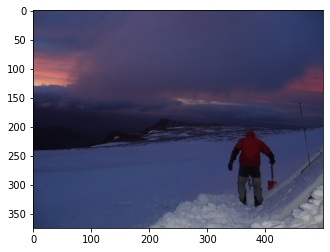

Beam index 3: person in red jacket is walking down snowy hill
Beam index 5: skier in red jacket is walking down snowy hill
Beam index 7: skier in red jacket is walking down snowy hill
Greedy: man in red jacket is walking down snowy hill


In [55]:
z= 5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))

x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()
print("Beam index 3: "+beamSearch(image,3,model2))
print("Beam index 5: "+beamSearch(image,5,model2))
print("Beam index 7: "+beamSearch(image,7,model2))

print("Greedy:",greedySearch(image,model2))

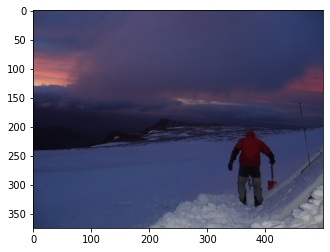

Beam index 3: man in blue jacket is skiing down hill
Beam index 5: man in yellow jacket is skiing down snowy hill
Beam index 7: man in blue coat is skiing down snowy hill
Greedy: skier is skiing down snowy hill


In [56]:
z= 5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))

x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()
print("Beam index 3: "+beamSearch(image,3,model1,'nic'))
print("Beam index 5: "+beamSearch(image,5,model1,'nic'))
print("Beam index 7: "+beamSearch(image,7,model1,'nic'))

print("Greedy:",greedySearch(image,model1,'nic'))

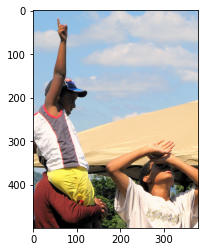

Beam index 3: young boy wearing blue shirt and blue shirt is raising his hand on the beach
Beam index 5: two young men are standing in the sand with their arms outstretched
Beam index 7: two young men are standing on the beach
Greedy: man in red shirt and blue shirt is raising his arms as he looks at the camera


In [57]:
z= 700
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))

x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()
print("Beam index 3: "+beamSearch(image,3,model2))
print("Beam index 5: "+beamSearch(image,5,model2))
print("Beam index 7: "+beamSearch(image,7,model2))

print("Greedy:",greedySearch(image,model2))

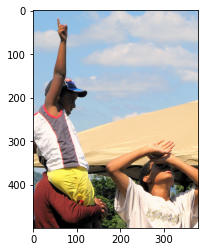

Beam index 3: young girl in pink shirt is standing on the grass with her arms outstretched arms
Beam index 5: two young girls are posing for picture with their arms outstretched
Beam index 7: two young girls are posing for picture with their arms outstretched
Greedy: man in blue shirt and shorts is holding up to his arms while standing on the grass


In [58]:
z= 700
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))

x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()
print("Beam index 3: "+beamSearch(image,3,model1,'nic'))
print("Beam index 5: "+beamSearch(image,5,model1,'nic'))
print("Beam index 7: "+beamSearch(image,7,model1,'nic'))

print("Greedy:",greedySearch(image,model1,'nic'))

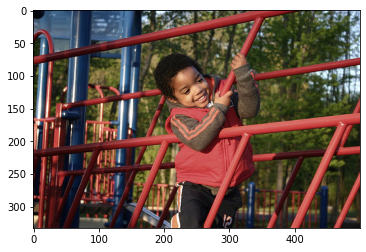

Beam index 3: little girl is swinging on swing
Beam index 5: little girl in red shirt is swinging on swing set
Beam index 7: little boy in red shirt is swinging on swing set
Greedy: young boy wearing red shirt and blue shirt is swinging on swing


In [59]:
z= 50
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))

x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()
print("Beam index 3: "+beamSearch(image,3,model2))
print("Beam index 5: "+beamSearch(image,5,model2))
print("Beam index 7: "+beamSearch(image,7,model2))

print("Greedy:",greedySearch(image,model2))

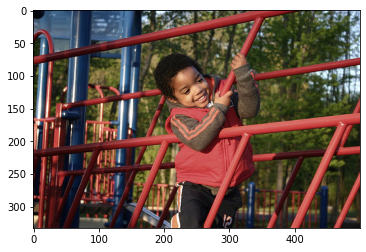

Beam index 3: two children are playing on swing set in front of an audience
Beam index 5: little girl in pink shirt is swinging on swing in front of large tree
Beam index 7: the boy in the blue shirt is swinging on swing at the park
Greedy: boy in blue shirt and jeans is swinging on swing set


In [60]:
z= 50
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))

x=plt.imread('Flicker8k_Dataset/'+pic)
plt.imshow(x)
plt.show()
print("Beam index 3: "+beamSearch(image,3,model1,'nic'))
print("Beam index 5: "+beamSearch(image,5,model1,'nic'))
print("Beam index 7: "+beamSearch(image,7,model1,'nic'))

print("Greedy:",greedySearch(image,model1,'nic'))